# Implement a SageMaker Real-time Single Model Endpoint (SME) for a TensorFlow Vision model on an NVIDIA Triton Server

NVIDIA Triton Inference Server is an open source software that provides high performance inference on a wide variety of CPU and GPU hardware and supports all the major ML frameworks. It has many built-in features to improve inference throughput and achieves better utilization of the resources.  

Now the NVIDIA Triton Inference Server can be deployed on GPU based SageMaker ML instances. It supports the SageMaker hosting service API serve deploy the inference endpoint. 

Amazon SageMaker hosting service is used to deploy a trained model to an endpoint that can be used for real-time inference. SageMaker real-time inference is ideal for inference workloads where you have interactive, low latency requirements. 

This notebook shows how to deploy a TensorFlow model trained on the MNIST dataset to a SageMaker real-time endpoint using the NVIDIA Triton Server. 

Here we use an existing model artifact. The model used here was pre-trained on the MNIST dataset. If you want to learn how to train the model, please See [TensorFlow script mode training and serving](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-python-sdk/tensorflow_script_mode_training_and_serving/tensorflow_script_mode_training_and_serving.ipynb). 

## Contents
1. [Introduction to NVIDIA Triton Server](#section1)
1. [Set up the environment](#section2)
1. [Transform TensorFlow model structure](#section3)
    1. [Inspect the model using a CLI command](#section3a)
    1. [Create the model configuration file](#section3b)
    1. [Create the tar ball in the required Triton structure](#section3c)
    1. [Upload the model artifact to S3](#section3d)
1. [Deploy the model to a SageMaker Triton Server Endpoint](#section4)
1. [Test the SageMaker Triton Server Endpoint for Inference](#section5)
1. [Clean up](#section6)

<a id='section1'></a>
## Introduction to NVIDIA Triton Server

[NVIDIA Triton Inference Server](https://github.com/triton-inference-server/server/) was developed specifically to enable scalable, cost-effective, and easy deployment of models in production. NVIDIA Triton Inference Server is open-source inference serving software that simplifies the inference serving process and provides high inference performance.

Some key features of Triton are:
* **Support for Multiple frameworks**: Triton can be used to deploy models from all major frameworks. Triton supports TensorFlow, ONNX, PyTorch, and many other model formats. 
* **Model pipelines**: Triton model ensemble represents a pipeline of one or more models or pre- / post-processing logic and the connection of input and output tensors between them. A single inference request to an ensemble will trigger the execution of the entire pipeline.
* **Concurrent model execution**: Multiple models (or multiple instances of the same model) can run simultaneously on the same GPU or on multiple GPUs for different model management needs.
* **Dynamic batching**: For models that support batching, Triton has multiple built-in scheduling and batching algorithms that combine individual inference requests together to improve inference throughput. These scheduling and batching decisions are transparent to the client requesting inference.
* **Diverse CPUs and GPUs**: The models can be executed on CPUs or GPUs for maximum flexibility and to support heterogeneous computing requirements.



<a id='section2'></a>
## Set up the environment

This notebook uses the Python 3 (Data Science) kernel. 

#### Install TensorFlow. This notebook is tested with version 2.11.

In [2]:
import sys

!{sys.executable} -m pip install "tensorflow>=2.1,<2.12"

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
# imports

import boto3, json, sagemaker, time
from sagemaker import get_execution_role
import numpy as np
from PIL import Image
import gzip
import matplotlib.pyplot as plt

#### For this exercise we download a TensorFlow model pre-trained on the MNIST data set from an Amazon S3 bucket. The model artifact is saved locally.

In [4]:
saved_model = "s3://sagemaker-sample-files/datasets/image/MNIST/model/tensorflow-training-2020-11-20-23-57-13-077/model.tar.gz"
!aws s3 cp $saved_model model/SavedModel/

download: s3://sagemaker-sample-files/datasets/image/MNIST/model/tensorflow-training-2020-11-20-23-57-13-077/model.tar.gz to model/SavedModel/model.tar.gz


#### You should have already configured the default IAM role for running this notebook with access to the model artifacts and the NVIDIA Triton Server image in Amazon Elastic Container Registry (ECR).

In [5]:
sm_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket_name = sm_session.default_bucket()
region = boto3.Session().region_name

print(f"Default IAM Role: {role}")
print(f"Default S3 Bucket: {bucket_name}")
print(f"AWS Region: {region}")

Default IAM Role: arn:aws:iam::095351214964:role/service-role/AmazonSageMaker-ExecutionRole-20200130T133110
Default S3 Bucket: sagemaker-us-east-1-095351214964
AWS Region: us-east-1


#### Download the Triton Server image from Amazon ECR.

In [6]:
# Amazon ECR images are region specific

triton_server_version = "23.02"

account_id_map = {
    "us-east-1": "785573368785",
    "us-east-2": "007439368137",
    "us-west-1": "710691900526",
    "us-west-2": "301217895009",
    "eu-west-1": "802834080501",
    "eu-west-2": "205493899709",
    "eu-west-3": "254080097072",
    "eu-north-1": "601324751636",
    "eu-south-1": "966458181534",
    "eu-central-1": "746233611703",
    "ap-east-1": "110948597952",
    "ap-south-1": "763008648453",
    "ap-northeast-1": "941853720454",
    "ap-northeast-2": "151534178276",
    "ap-southeast-1": "324986816169",
    "ap-southeast-2": "355873309152",
    "cn-northwest-1": "474822919863",
    "cn-north-1": "472730292857",
    "sa-east-1": "756306329178",
    "ca-central-1": "464438896020",
    "me-south-1": "836785723513",
    "af-south-1": "774647643957",
}

if region not in account_id_map.keys():
    raise ("UNSUPPORTED REGION")

base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"

sme_triton_image_uri = "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:{triton_server_version}-py3".format(
    account_id=account_id_map[region],
    region=region,
    base=base,
    triton_server_version=triton_server_version,
)

print(f"Triton server image: {sme_triton_image_uri}")

Triton server image: 785573368785.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tritonserver:23.02-py3


In [7]:
# Extract the model into a local folder

!tar -xf model/SavedModel/model.tar.gz -C model/SavedModel/ --no-same-owner

<a id='section3'></a>

## Transform TensorFlow Model structure


The model that we want to deploy currently has the following structure:

```
00000000
        ├── saved_model.pb
        ├── assets/
        └── variables/
            ├── variables.data-00000-of-00001
            └── variables.index
```
For Triton, the model needs to have the following structure:
```
<model-name>
├── config.pbtxt
└── 1
    └── model.savedmodel
        ├── saved_model.pb
        ├── assets/
        └── variables/
            ├── variables.data-00000-of-00001
            └── variables.index
            

```

In [8]:
prefix = "triton-sme"

# Reorganize the model structure that is required by Triton Server.
! mkdir -p model/$prefix/MNIST/1
! cp model/SavedModel/00000000 --recursive ./model/$prefix/MNIST/1/model.savedmodel/

<a id='section3a'></a>
### Inspect the model using a CLI command.

In order to create the `config.pbtxt` we need to confirm the model inputs and outputs (Signature).
We use the CLI command to inspect the model and take note of the input and output shape.

In [9]:
!saved_model_cli show --all --dir  {"model/SavedModel/00000000"}

2023-04-02 18:11:04.711813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 18:11:04.937213: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-02 18:11:04.937260: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-02 18:11:06.333387: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

<a id='section3b'></a>
### Create the `config.pbtxt` file

Triton requires a [Model Configuration file](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md) known as a `config.pbtxt`. 

We create one below in the local folder for adding to the model artifact.

In [10]:
%%writefile model/triton-sme/MNIST/config.pbtxt
name: "MNIST"
platform: "tensorflow_savedmodel"
max_batch_size: 0

instance_group {
  count: 1
  kind: KIND_GPU
}

dynamic_batching {

}

input [
  {
    name: "input_1"
    data_type: TYPE_FP32
    dims: [-1, 28, 28, 1]
  }
]
output [
  {
    name: "output_1"
    data_type: TYPE_FP32
    dims: [-1, 10]
  }
]

Overwriting model/triton-sme/MNIST/config.pbtxt


<a id='section3c'></a>
### Create a tar ball of the model in the required folder structure for Triton

In [11]:
!tar -C model/triton-sme -czvf model/triton-sme/TritonModel.tar.gz MNIST/

MNIST/
MNIST/config.pbtxt
MNIST/1/
MNIST/1/model.savedmodel/
MNIST/1/model.savedmodel/00000000/
MNIST/1/model.savedmodel/00000000/variables/
MNIST/1/model.savedmodel/00000000/variables/variables.data-00000-of-00001
MNIST/1/model.savedmodel/00000000/variables/variables.index
MNIST/1/model.savedmodel/00000000/saved_model.pb
MNIST/1/model.savedmodel/00000000/assets/
MNIST/1/model.savedmodel/variables/
MNIST/1/model.savedmodel/variables/variables.data-00000-of-00001
MNIST/1/model.savedmodel/variables/variables.index
MNIST/1/model.savedmodel/saved_model.pb
MNIST/1/model.savedmodel/assets/


<a id='section3d'></a>
### Upload model artifact to Amazon S3

In [12]:
# specify the model location in S3
model_location = f"s3://{bucket_name}/{prefix}/TritonModel.tar.gz"

# Upload the model to S3
!aws s3 cp model/$prefix/TritonModel.tar.gz $model_location

upload: model/triton-sme/TritonModel.tar.gz to s3://sagemaker-us-east-1-095351214964/triton-sme/TritonModel.tar.gz


<a id='section4'></a>
## Deploy the TensorFlow model to a SageMaker real-time Endpoint


### Create a SageMaker Model object


In the model definition below, we need to pass in the following parameters.
- Location of model in S3
- SageMaker execution role
- An environment \variable with name of the model
- Triton server image container URI in Amazon ECR


### Create a model object

Create a SageMaker model from the model files we uploaded to s3 in the previous step.

In [13]:
from sagemaker.model import Model

tensorflow_model = Model(
    model_data=model_location,
    role=role,
    env={"SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "MNIST"},
    image_uri=sme_triton_image_uri,
)

## Deploy and test the NVIDIA Triton server endpoint

Create the model to a SageMaker endpoint. 
We specify an accelerated GPU computing instance as the instance type. For testing we specify a single instance. In real scenarios we recommend the value of initial instance count to be two or higher for high availability.  

### Create Real-time Endpoint

Using the above endpoint configuration we create a new SageMaker endpoint and wait for the deployment to finish. The status will change to *In Service* once the deployment is successful.

In [14]:
%%time

ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

# Use timestamp in endpoint name to make it unique
endpoint_name = f"{prefix}-mnist-ep-{ts}"

predictor = tensorflow_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge",
    endpoint_name=endpoint_name,
)

-----------!CPU times: user 238 ms, sys: 48.6 ms, total: 287 ms
Wall time: 6min 3s


<a id='section5'></a>
## Invoke the model behind the NVIDIA Triton Server Endpoint

Once the endpoint is successfully created, we can send inference request to the endpoint using invoke_endpoint API. We specify the target model in the invocation call and pass in the payload.

### Let's download some test data


In [15]:
!aws --region {region} s3 cp s3://sagemaker-sample-files/datasets/image/MNIST/t10k-images-idx3-ubyte.gz ./
!aws --region {region} s3 cp s3://sagemaker-sample-files/datasets/image/MNIST/t10k-labels-idx1-ubyte.gz ./

download: s3://sagemaker-sample-files/datasets/image/MNIST/t10k-images-idx3-ubyte.gz to ./t10k-images-idx3-ubyte.gz
download: s3://sagemaker-sample-files/datasets/image/MNIST/t10k-labels-idx1-ubyte.gz to ./t10k-labels-idx1-ubyte.gz


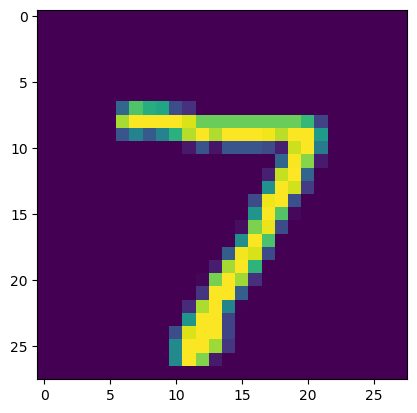

Label: 7.0


In [16]:
# Open the images file and extract the first 10 images
file = gzip.open("t10k-images-idx3-ubyte.gz", "r")

record_count = 10

file.read(16)  # skip first 16 bytes of metadata
buf = file.read(28 * 28 * record_count)
train_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
train_data = train_data.reshape(record_count, 28, 28, 1)

# Open the labels file and extract the first 10 labels
file = gzip.open("t10k-labels-idx1-ubyte.gz", "r")

train_labels = np.array([])
file.read(8)  # skip first 8 bytes of metadata
for i in range(0, record_count):
    buf = file.read(1)
    # label = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    label = np.frombuffer(buf, dtype=np.int8)
    train_labels = np.append(train_labels, label)

plt.imshow(np.asarray(train_data[0]).squeeze())
plt.show()

print(f"Label: {train_labels[0]}")

In [17]:
%%time

runtime_sm_client = boto3.client("sagemaker-runtime")

for i in range(10):
    payload = {
        "inputs": [
            {
                "name": "input_1",
                "shape": [1, 28, 28, 1],
                "datatype": "FP32",
                "data": train_data[i].tolist(),
            }
        ]
    }

    response = runtime_sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="application/octet-stream",
        Body=json.dumps(payload),
    )

    predictions = json.loads(response["Body"].read())["outputs"][0]["data"]
    predictions = np.array(predictions, dtype=np.float32)
    predictions = np.argmax(predictions)
    print(f"Predicted value: {predictions},\tActual value: {int(train_labels[i])}")

Predicted value: 7,	Actual value: 7
Predicted value: 2,	Actual value: 2
Predicted value: 1,	Actual value: 1
Predicted value: 0,	Actual value: 0
Predicted value: 4,	Actual value: 4
Predicted value: 1,	Actual value: 1
Predicted value: 4,	Actual value: 4
Predicted value: 9,	Actual value: 9
Predicted value: 6,	Actual value: 5
Predicted value: 9,	Actual value: 9
CPU times: user 205 ms, sys: 34.6 ms, total: 240 ms
Wall time: 3.99 s


<a id='section6'></a>
## Clean up
We strongly recommend deleting the endpoint and other resources to stop incurring cost when finished with the example.

In [18]:
# Using the endpoint name, get the endpoint configuration and model name for deletion.

sm_client = boto3.client(service_name="sagemaker")

ep_resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
endpoint_config_name = ep_resp["EndpointConfigName"]

ep_config_resp = sm_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
model_name = ep_config_resp["ProductionVariants"][0]["ModelName"]

sm_client.delete_endpoint(EndpointName=endpoint_name)
print(f"Deleted Endpoint: {endpoint_name}")

sm_client.delete_model(ModelName=model_name)
print(f"Deleted Model: {model_name}")

sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
print(f"Deleted Endpoint Config: {endpoint_config_name}")

Deleted Endpoint: triton-sme-mnist-ep-2023-04-02-18-11-11
Deleted Model: sagemaker-tritonserver-2023-04-02-18-11-11-293
Deleted Endpoint Config: triton-sme-mnist-ep-2023-04-02-18-11-11
